# 1. Deep Q-Learning for Navigation
---

In this notebook I will solve the [Unity ML Banana-Collector environment](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#banana-collector) using Deep Q-Learning as described in [Human-level control through deep reinforcement learning](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf).  In follow up notebooks I'll improve on this solution.  See the [README](https://github.com/bobflagg/Deep-Q-Learning-for-Navigation/blob/master/README.md) for instructions on how to setup your environment to run the code here.

The goal of the Navigation Project is to train an agent to navigate (and collect bananas!) in a large, square world.
A reward of +1 is provided for collecting a yellow banana, and a reward of -1 is provided for collecting a blue banana. Thus, the goal of the agent is to collect as many yellow bananas as possible while avoiding blue bananas.

The state space has 37 dimensions and contains the agent's velocity, along with ray-based perception of objects around the agent's forward direction. Given this information, the agent has to learn how to best select actions. Four discrete actions are available, corresponding to:

- [**0**] move forward.
- [**1**] move backward.
- [**2**] turn left.
- [**3**] turn right.

The task is episodic, and in order to solve the environment, the agent must get an average score of +13 over 100 consecutive episodes.


## Background


The [Unity ML Banana-Collector](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#banana-collector) is a *sequential decision making problem*, in which an agent interacts with an environment over discrete time steps and tries to find a policy to maximize the expected discounted return:
$$G_t = \sum_{\tau=t}^{\infty}\gamma^{\tau-t}R_\tau,$$
where $\gamma\in [0, 1]$ is a discount factor that trades-off the importance of immediate and future rewards. See [Sutton and Barto](http://incompleteideas.net/book/the-book.html) for a general discussion of this sort of problem.

In these notebooks I'll focus on a particular class of algorithms for 
solving sequential decision making problems called **Q-learning**. The main idea behind Q-Learning is that if we had a function 
$$Q^*:{\cal S} \times {\cal A}:\to\mathbb{R},$$
where ${\cal S}$ is the set of states and ${\cal A}$ is the set of possible actions, that could tell us what our return would be, if we were to take an action in a given state, then we could easily construct a policy that maximizes our rewards:
$$\pi^*(s) = \operatorname{arg\,max}_{a} Q^*(s,a).$$
Unfortunately we don't know enough about the environment to compute $Q^*(s,a)$. One approach to overcome this problem is [Q-learning](http://www.cs.rhul.ac.uk/~chrisw/new_thesis.pdf), 
an early breakthrough in reinforcement learning.   Q-learning approximates the optimal action-value function with a learned action-value function $Q(s,a)$, which 
is initialized randomly and then updated incrementally according to the formula
$$Q(S_t,A_t) \leftarrow (1-\alpha)\cdot Q(S_t,A_t) + \alpha \cdot \big[R_{t+1}+\gamma \cdot \max_a Q(S_{t+1},a)\big].$$
In the standard Q-learning implementation Q-values are stored in a table.
One cell is required per combination of state and action. This implementation
is not amenable to continuous state problems like the Unity ML-Agent Banana Collector.
The simplest way to get around this is to apply discretization but that scales poorly: as the number of
state and action variables increase, the size of the table used to store Q-values
grows exponentially. The next section describes an alternative to discretized Q-learning, which scales well.

## Deep Q-Learning

<img src="doc/images/dqn.png" alt="Deep Q-Network" style="margin-left: 140px;; margin-right: 100px;" />
     
Deep Q-learning is an alternative to discretized Q-learning, which addresses the scaling problem by approximating $Q^*(s,a)$ 
with a *deep Q-network*, $Q(s,a|\theta)$, and tuning the parameters by optimizing the following
of loss function:
$$L(\theta) = \mathbb{E}\big[\big(y^{DQN}-Q(S_t, A_t|\theta)\big)^2\big],$$
with 
$$ y^{DQN}=R_t+\gamma\cdot\max_{a'}Q(S_{t+1},a'|\theta^-),$$
where $\theta^-$ representes the parameters of a fixed and separate *target network*. Another key innovation of deep Q-learning is the use of a *replay buffer* which stores experience tuples while interacting with the environment for sampling later in training the neural network.  This device eliminates unwanted correlation between consecutive states in an episode.

## Q-Network

The implementation for my Q-network is taken directly from the [course solution](https://github.com/udacity/deep-reinforcement-learning/tree/master/dqn/solution) to the [Deep Q-Learning Coding Exercise](https://github.com/udacity/deep-reinforcement-learning/tree/master/dqn).  It has three fully connected linear layers with [ReLu](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation functions.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed=0, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

## Deep Q-Learning Agent

My code for a [deep Q-learning agent](https://github.com/bobflagg/Deep-Q-Learning-for-Navigation/blob/master/dqn_agent.py) is also taken directly from the [course solution](https://github.com/udacity/deep-reinforcement-learning/tree/master/dqn/solution) to the [Deep Q-Learning Coding Exercise].

The behavior of this agent depends on several hyperparameters, including: 

- BATCH_SIZE = the size of batches used when updating parameters via gradient descent;
- BUFFER_SIZE = the number of samples to store in the replay buffer for later sampling;
- GAMMA = a real number in [0,1] that sets the trade-off in the importance of immediate and future rewards;
- LR = the coefficient applied to the gradient vector is a gradient update step;
- TAU = the weight applied to the target parameters in the soft update of the local network parameters; and
- UPDATE_EVER = how often to run the soft update of the local network parameters.

Initially, I'll take values for these hyperparameters suggested in the course example.

In [2]:
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3
LR = 5e-4
UPDATE_EVERY = 4

The replay buffer which stores experience tuples while interacting with the environment for sampling later in training the neural network can be implemented as a simple queue.

In [3]:
from collections import namedtuple, deque

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

My code for the [DQN-Agent](https://github.com/bobflagg/Deep-Q-Learning-for-Navigation/blob/master/dqn_agent.py) is also taken directly from the [course solution](https://github.com/udacity/deep-reinforcement-learning/tree/master/dqn/solution) to the [Deep Q-Learning Coding Exercise](https://github.com/udacity/deep-reinforcement-learning/tree/master/dqn).

In [4]:
import numpy as np
import random
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.0):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad(): action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps: return np.argmax(action_values.cpu().data.numpy())
        else: return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

## Training

I'll make a small change to the implementation provided in the [course solution](https://github.com/udacity/deep-reinforcement-learning/tree/master/dqn/solution) to the [Deep Q-Learning Coding Exercise](https://github.com/udacity/deep-reinforcement-learning/tree/master/dqn) by adding code to plot scores.

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline  

def train(env, agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    # get the default brain
    brain_name = env.brain_names[0]
    #brain = env.brains[brain_name]
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0] 
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done: break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.axhline(y=13, color='r', linestyle='-')
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()
    return scores

I'm finally ready to train a deep Q-learning model.

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode 100	Average Score: 0.51
Episode 200	Average Score: 3.57
Episode 300	Average Score: 7.84
Episode 400	Average Score: 8.63
Episode 500	Average Score: 12.72
Episode 506	Average Score: 13.01
Environment solved in 406 episodes!	Average Score: 13.01


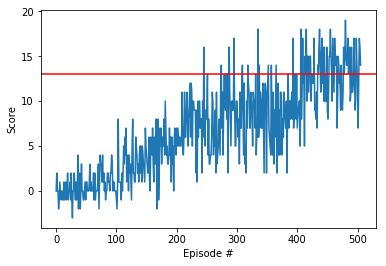

CPU times: user 3min 29s, sys: 23.3 s, total: 3min 52s
Wall time: 7min 54s


In [6]:
%%time

from unityagents import UnityEnvironment
env = UnityEnvironment(file_name="./data/Banana.app")

agent = Agent(state_size=37, action_size=4, seed=0)
scores = train(env, agent)

So the [Unity ML Banana-Collector environment](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#banana-collector)
was solved in about 400 episodes! Not bad at all.  

I'll save the weights of the local network of this successful agent to the file dqn-model-weights.pth.

In [7]:
torch.save(agent.qnetwork_local.state_dict(), 'dqn-model-weights.pth')

Now let's reload the local network weights and see how the network fairs in yellow banana collecting. 

**Note:** To get the cell below to work I had to restart the kernel and run all the cells above except the training cell.

In [11]:
from tqdm import tqdm
from unityagents import UnityEnvironment

network = QNetwork(state_size=37, action_size=4, seed=0)
network.load_state_dict(torch.load('dqn-model-weights.pth'))
network.eval()

def act(network, state):
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    with torch.no_grad(): action_values = network(state)
    return np.argmax(action_values.cpu().data.numpy())

env = UnityEnvironment(file_name="./data/Banana.app")
env_info = env.reset(train_mode=True)[brain_name]
state = env_info.vector_observations[0]
score = 0.0

for step in tqdm(range(1000)):
    action = act(network, state)
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    score += reward
    state = next_state
    if done: break
    
    
print("Average Score: {}".format(score))

OSError: handle is closed

ERROR:root:Exception calling application: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/Users/rflagg/anaconda3/envs/drlnd/lib/python3.6/site-packages/grpc/_server.py", line 385, in _call_behavior
    return behavior(argument, context), True
  File "/Users/rflagg/anaconda3/envs/drlnd/lib/python3.6/site-packages/unityagents/rpc_communicator.py", line 25, in Exchange
    self.child_conn.send(request)
  File "/Users/rflagg/anaconda3/envs/drlnd/lib/python3.6/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/rflagg/anaconda3/envs/drlnd/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/rflagg/anaconda3/envs/drlnd/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
